# Implementing Alexnet With Batch Normalization

## Animal Classifier

In [1]:
import os
import shutil
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

np.random.seed(1000)

Using TensorFlow backend.


## 1. Loading Data

#### 1.1 Defining Required Dataset Paths 

In [2]:
BASE_FOLDER_PATH = "Dataset/AnimalDataset/"
DATA_PATH = BASE_FOLDER_PATH + "All_Images/"
TRAIN_PATH = BASE_FOLDER_PATH + "Train_Images/"
VALID_PATH = BASE_FOLDER_PATH + "Validation_Images/"

#### 1.2 Checking The Total Number Of Images In Dataset Of Each Class

In [3]:
folders = os.listdir(DATA_PATH)
for f in folders:
    path = DATA_PATH + f
    print(str(len(os.listdir(path))) + " Images For " + str(f).upper() + " Class")

202 Images For CATS Class
202 Images For DOGS Class
202 Images For HORSES Class
202 Images For HUMANS Class


 - **We Need To Split Our Data Into Separate Folders For Training And Validation So That We Can Make Training And Validation Generators Later**

#### 1.3 Creating Training and Validation Images Directory If Not Available

In [4]:
if not os.path.isdir(TRAIN_PATH):
    os.mkdir(TRAIN_PATH)
    
if not os.path.isdir(VALID_PATH):
    os.mkdir(VALID_PATH)

#### 1.4 Creating Subfolders For Each Class In Both Training and Validation Images Directory 

In [5]:
classes = ["dogs", "cats", "horses", "humans"]

for each_class in classes:
    sub_path_train = os.path.join(TRAIN_PATH, each_class)
    sub_path_valid = os.path.join(VALID_PATH, each_class)
    
    if not os.path.isdir(sub_path_train):
        os.mkdir(sub_path_train)
        
    if not os.path.isdir(sub_path_valid):
        os.mkdir(sub_path_valid)

#### 1.5 Splitting The Data And Copying It To The Created Directories

In [6]:
SPLIT = 0.9

for classSubFolder in os.listdir(DATA_PATH):
    
    # Iterating Over Each Class Folder     
    cur_class_path = DATA_PATH + classSubFolder
    images_cur_class = os.listdir(cur_class_path)
    
    # Splitting The Data Into Train And Validation Images For Current Class
    split_size = int(SPLIT*len(images_cur_class))
    train_images = images_cur_class[:split_size]
    valid_images = images_cur_class[split_size:]
    print("\n# Training Images For " + str(classSubFolder).upper() + " : " + str(len(train_images)))
    print("Validation Images For " + str(classSubFolder).upper() + " : " + str(len(valid_images)))
    
    # Copying Training Images
    for image_path in train_images:
        src_path = os.path.join(cur_class_path, image_path)
        dest_path = os.path.join(TRAIN_PATH + classSubFolder, image_path)
        shutil.copy(src_path, dest_path)
        
    # Copying Validation Images    
    for image_path in valid_images:
        src_path = os.path.join(cur_class_path, image_path)
        dest_path = os.path.join(VALID_PATH + classSubFolder, image_path)
        shutil.copy(src_path, dest_path)


# Training Images For CATS : 181
Validation Images For CATS : 21

# Training Images For DOGS : 181
Validation Images For DOGS : 21

# Training Images For HORSES : 181
Validation Images For HORSES : 21

# Training Images For HUMANS : 181
Validation Images For HUMANS : 21


## 2. Creating Training And Validation Generators (With No Data Augmentation)

 - A Image Data Generator First Goes To The Base Directory Specified
 - Then It Reads Images According To The Subfolders Name As Classes.
 - Then It Convert Images Into Arrays And Apply Required Operations.
 - It Also Converts The Class Labels Into One Hot Vectors.
 - Thus This Can Be Used To Easily Feed The Data To Any Model.
 - This Helps To Load Large Datasets In Form Of Small Batches.
 - These Batches Can Be Feed One By One To The Model

#### 2.1 Training Generator

In [7]:
train_gen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_gen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 724 images belonging to 4 classes.


#### 2.2 Validation Generator

In [8]:
val_gen = ImageDataGenerator(rescale=1.0/255.0)
validation_generator = val_gen.flow_from_directory(
    VALID_PATH,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

Found 84 images belonging to 4 classes.


## 3. Visualising The Data

#### 3.1 Visualising The Training Images


Shape Of X_Train (For 1 Batch) :  (32, 224, 224, 3)

Shape Of Y_Train (For 1 Batch) :  (32, 4)

One Batch Of Training Images


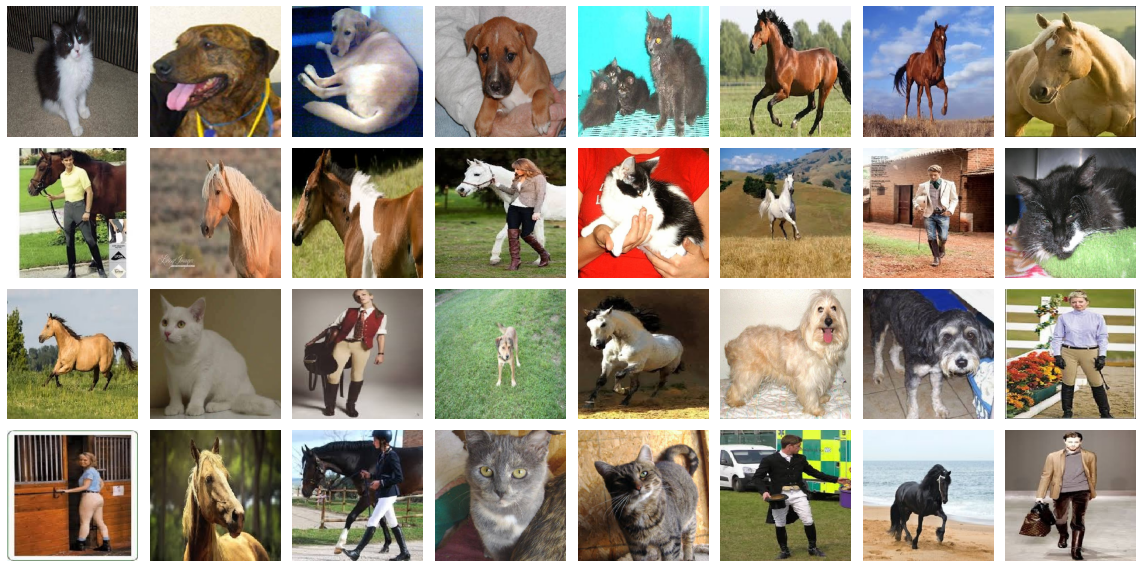

In [9]:
for x, y in train_generator:
    print("\nShape Of X_Train (For 1 Batch) : ", x.shape)
    print("\nShape Of Y_Train (For 1 Batch) : ", y.shape)
    plt.figure(figsize=(16,8))
    for i in range(1, len(x)+1):
        plt.subplot(4,8,i)
        plt.imshow(x[i-1])
        plt.axis("off")
    plt.tight_layout()
    print("\nOne Batch Of Training Images")
    plt.show()
    break

#### 3.1 Visualising The Validation Images


Shape Of X_Validation (For 1 Batch) :  (16, 224, 224, 3)

Shape Of Y_Validation (For 1 Batch) :  (16, 4)

One Batch Of Validation Images


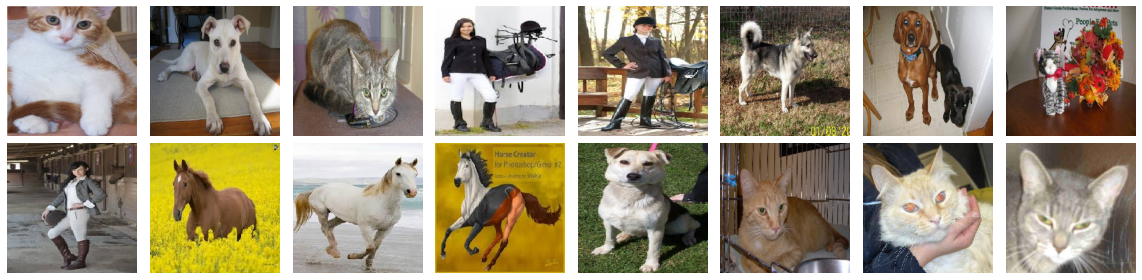

In [10]:
for x, y in validation_generator:
    print("\nShape Of X_Validation (For 1 Batch) : ", x.shape)
    print("\nShape Of Y_Validation (For 1 Batch) : ", y.shape)
    plt.figure(figsize=(16,4))
    for i in range(1, len(x)+1):
        plt.subplot(2,8,i)
        plt.imshow(x[i-1])
        plt.axis("off")
    plt.tight_layout()
    print("\nOne Batch Of Validation Images")
    plt.show()
    break
# Mini Batch of 32 images

## 4. Defining The CNN Model

In [11]:
model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolution Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolution Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolution Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolution Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing It To A Fully Connected Layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224,224,3)))
model.add(Activation('relu'))

# Dropout Layer To Prevent Overfitting
model.add(Dropout(0.4))

# 2nd FC Layer
model.add(Dense(1000))
model.add(Activation('relu'))

# Dropout
model.add(Dropout(0.4))

# 3rd FC
model.add(Dense(4))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)        

## 5. Compiling The Model

In [12]:
adam = optimizers.adam(lr=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## 6. Training The Model

- Training The Model Using Train And Validation Generator.
- **model.fit( )** -> Useful When Dataset Is Small And It Can Fit Inside The Memory.
- **model.fit_generator( )** -> Useful When The Dataset Is Large And Can't Fit Inside The Memory.

In [13]:
print("The Labels We Got : ", set(train_generator.labels))

The Labels We Got :  {0, 1, 2, 3}


In [14]:
history = model.fit_generator(
    train_generator,
    epochs = 35,
    steps_per_epoch = 5, # Batchs Per Epoch
    validation_data=validation_generator,
    validation_steps = 4  
)

Epoch 1/35
5/5 [==============================] - 9s 2s/step - loss: 1.3904 - accuracy: 0.1875 - val_loss: 1.3847 - val_accuracy: 0.2656
Epoch 2/35
5/5 [==============================] - 9s 2s/step - loss: 1.3882 - accuracy: 0.2313 - val_loss: 1.3805 - val_accuracy: 0.3077
Epoch 3/35
5/5 [==============================] - 9s 2s/step - loss: 1.3794 - accuracy: 0.2770 - val_loss: 1.3071 - val_accuracy: 0.2500
Epoch 4/35
5/5 [==============================] - 8s 2s/step - loss: 1.3898 - accuracy: 0.1937 - val_loss: 1.3675 - val_accuracy: 0.2812
Epoch 5/35
5/5 [==============================] - 8s 2s/step - loss: 1.3917 - accuracy: 0.1875 - val_loss: 1.3893 - val_accuracy: 0.1538
Epoch 6/35
5/5 [==============================] - 8s 2s/step - loss: 1.3798 - accuracy: 0.3063 - val_loss: 1.3898 - val_accuracy: 0.3077
Epoch 7/35
5/5 [==============================] - 7s 1s/step - loss: 1.3813 - accuracy: 0.2297 - val_loss: 1.3064 - val_accuracy: 0.2656
Epoch 8/35
5/5 [=========================

## 7. Visualising The Results

#### 7.1 Training And Validation Accuracy

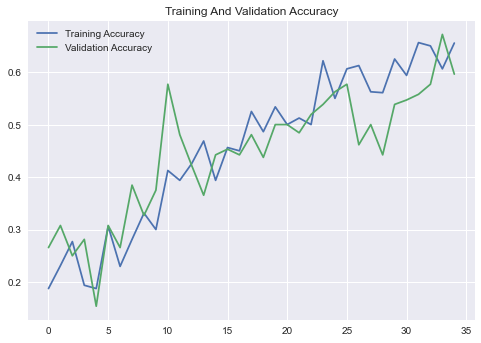

In [15]:
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

plt.style.use("seaborn")
plt.plot(train_acc, label="Training Accuracy")
plt.plot(valid_acc, label="Validation Accuracy")
plt.title("Training And Validation Accuracy")
plt.legend()
plt.show()

#### 7.2 Training And Validation Loss

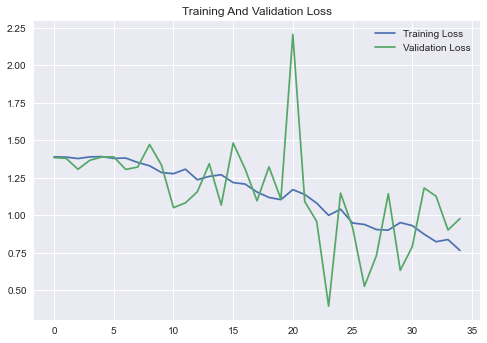

In [16]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

plt.style.use("seaborn")
plt.plot(train_loss, label="Training Loss")
plt.plot(valid_loss, label="Validation Loss")
plt.title("Training And Validation Loss")
plt.legend()
plt.show()

## 8. Results

#### 8.1 Training Accuracy

In [17]:
train_loss, train_accuracy = model.evaluate_generator(train_generator)
print("\nTraining Accuracy : ", 100 * round(train_accuracy, 4), "%")


Training Accuracy :  67.27 %


#### 8.2 Validation Accuracy

In [18]:
valid_loss, valid_accuracy = model.evaluate_generator(validation_generator)
print("\nValidation Accuracy : ", 100 * round(valid_accuracy, 4), "%")


Validation Accuracy :  57.14 %


# Data Augmentation In Image Pipelines

 - **We Can See That The Model Is Overfitting And Their Is A Lot Of Inconsistency In Training And Validation Accuracies And Losses.**
 
 - **This Is Due To The Small Quantity Of Dataset.**
 
 - **So, We Will Use The Regularization Technique Known As Data Augmentation.**
 
 - **This Will Help Us Create Different Images With Different Operations Applied To Them.**
 
 - **This Should Help To Reduce Overfitting By Making The Model More Robust.**

## 9. Creating Training And Validation Generators With Data Augmentation

#### 9.1 Training Image Generator

In [19]:
train_image_gen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.3,
    horizontal_flip = True
)

train_generator_aug = train_image_gen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 724 images belonging to 4 classes.


#### 9.2 Validation Image Generator

 - No Augmentation Is Done On Validation Data 

In [20]:
val_image_gen = ImageDataGenerator(rescale=1.0/255.0)
validation_generator_aug = val_image_gen.flow_from_directory(
    VALID_PATH,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

Found 84 images belonging to 4 classes.


## 10. Visualising The Augmented Data

 - Only Training Data Is Augmented, So, We Will Visualise That Only. 


Shape Of X_Train (For 1 Batch) :  (32, 224, 224, 3)

Shape Of Y_Train (For 1 Batch) :  (32, 4)

One Batch Of Augmented Training Images


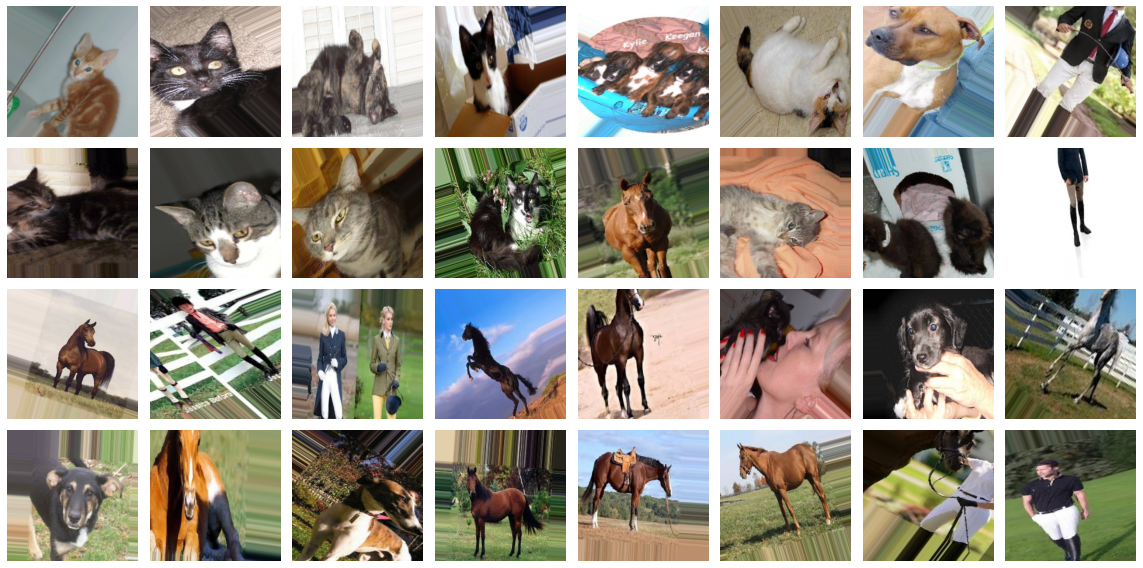

In [21]:
for x, y in train_generator_aug:
    print("\nShape Of X_Train (For 1 Batch) : ", x.shape)
    print("\nShape Of Y_Train (For 1 Batch) : ", y.shape)
    plt.figure(figsize=(16,8))
    for i in range(1, len(x)+1):
        plt.subplot(4,8,i)
        plt.imshow(x[i-1])
        plt.axis("off")
    plt.tight_layout()
    print("\nOne Batch Of Augmented Training Images")
    plt.show()
    break

## 11. Defining New CNN Model For Augmented Data

In [22]:
model_aug = Sequential()

# 1st Convolution Layer
model_aug.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model_aug.add(Activation('relu'))
# Max Pooling
model_aug.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolution Layer
model_aug.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model_aug.add(Activation('relu'))
# Max Pooling
model_aug.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolution Layer
model_aug.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model_aug.add(Activation('relu'))

# 4th Convolution Layer
model_aug.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model_aug.add(Activation('relu'))

# 5th Convolution Layer
model_aug.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model_aug.add(Activation('relu'))
# Max Pooling
model_aug.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing It To A Fully Connected Layer
model_aug.add(Flatten())

# 1st Fully Connected Layer
model_aug.add(Dense(4096, input_shape=(224,224,3)))
model_aug.add(Activation('relu'))

# Dropout Layer To Prevent Overfitting
model_aug.add(Dropout(0.4))

# 2nd FC Layer
model_aug.add(Dense(1000))
model_aug.add(Activation('relu'))

# Dropout
model_aug.add(Dropout(0.4))

# 3rd FC
model_aug.add(Dense(4))
model_aug.add(Activation('softmax'))

model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_9 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_10 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 384)        

## 12. Compiling And Training The New CNN Model

In [23]:
adam = optimizers.adam(lr=1e-4)
model_aug.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model_aug.fit_generator(
    train_generator_aug,
    epochs = 60,
    steps_per_epoch = 5,
    validation_data=validation_generator_aug,
    validation_steps = 4  
)

Epoch 1/60
5/5 [==============================] - 8s 2s/step - loss: 1.3867 - accuracy: 0.2095 - val_loss: 1.3687 - val_accuracy: 0.2500
Epoch 2/60
5/5 [==============================] - 8s 2s/step - loss: 1.3955 - accuracy: 0.2500 - val_loss: 1.3792 - val_accuracy: 0.2692
Epoch 3/60
5/5 [==============================] - 9s 2s/step - loss: 1.3875 - accuracy: 0.2125 - val_loss: 1.3911 - val_accuracy: 0.2692
Epoch 4/60
5/5 [==============================] - 8s 2s/step - loss: 1.3846 - accuracy: 0.2438 - val_loss: 1.3979 - val_accuracy: 0.2344
Epoch 5/60
5/5 [==============================] - 8s 2s/step - loss: 1.3863 - accuracy: 0.2688 - val_loss: 1.3838 - val_accuracy: 0.3077
Epoch 6/60
5/5 [==============================] - 8s 2s/step - loss: 1.3909 - accuracy: 0.2250 - val_loss: 1.3893 - val_accuracy: 0.2115
Epoch 7/60
5/5 [==============================] - 8s 2s/step - loss: 1.3830 - accuracy: 0.2432 - val_loss: 1.3842 - val_accuracy: 0.2344
Epoch 8/60
5/5 [=========================

5/5 [==============================] - 8s 2s/step - loss: 1.0461 - accuracy: 0.5938 - val_loss: 1.6882 - val_accuracy: 0.5962


## 13. Visualising The Results Generated By The Model With Data Augmentation

#### 13.1 Training And Validation Accuracy


Training Accuracy :  58.2873 %

Validation Accuracy :  60.7143 %


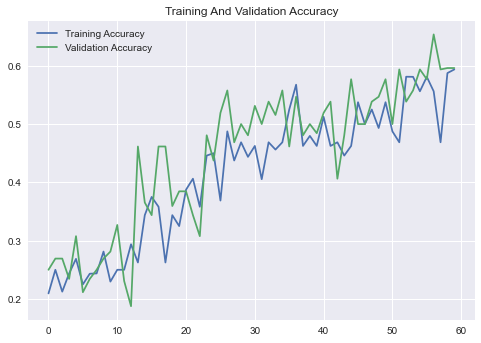

In [24]:
train_loss, train_accuracy = model_aug.evaluate_generator(train_generator_aug)
print("\nTraining Accuracy : ", round(100 * train_accuracy, 4), "%")

valid_loss, valid_accuracy = model_aug.evaluate_generator(validation_generator_aug)
print("\nValidation Accuracy : ", round(100 * valid_accuracy, 4), "%")

train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

plt.style.use("seaborn")
plt.plot(train_acc, label="Training Accuracy")
plt.plot(valid_acc, label="Validation Accuracy")
plt.title("Training And Validation Accuracy")
plt.legend()
plt.show()

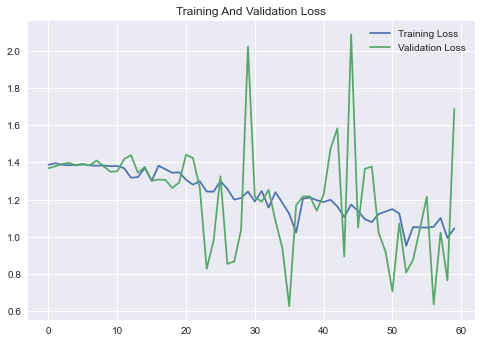

In [25]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

plt.style.use("seaborn")
plt.plot(train_loss, label="Training Loss")
plt.plot(valid_loss, label="Validation Loss")
plt.title("Training And Validation Loss")
plt.legend()
plt.show()

**There Is Not Any Improvement In The Accuracy But Data Augmentation Helped Us In Reducing The Overfitting. It's Clearly Visible That The Model Got Rid Of Overfitting. Accuracy Is Low As Deep Networks Like Alexnet Need More Quantity Of Data To Train On.**